In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, ops
import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from tqdm import tqdm
import numpy as np
from training_and_evaluate import train_and_eval
import pickle

In [6]:
BATCH_SIZE = 32
NUM_OF_WORKERS = 2
NUM_OF_EPOCHS = 40
NAME_OF_MODEL = "deformable_cnn"
EARLY_STOPPING_PATIENCE = 15

trainset = datasets.FashionMNIST('data', download=True, train=True, transform=transforms.ToTensor())
testset = datasets.FashionMNIST('data', download=True, train=False, transform=transforms.ToTensor())

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

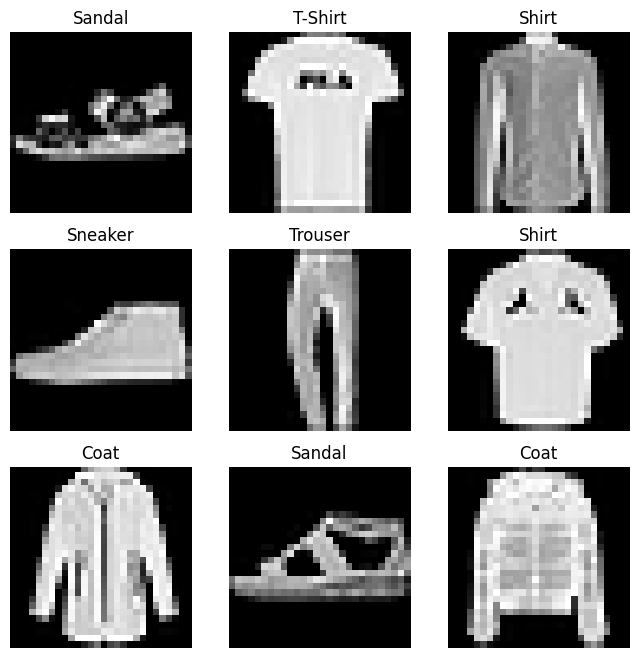

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(trainset), size=(1,)).item()
    img, label = trainset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [5]:
class DeformableConv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 stride=1,
                 padding=1,
                 bias=False):

        super(DeformableConv2d, self).__init__()

        self.padding = padding
        
        self.offset_conv = nn.Conv2d(in_channels, 
                                     2 * kernel_size * kernel_size,
                                     kernel_size=kernel_size, 
                                     stride=stride,
                                     padding=self.padding, 
                                     bias=True)

        nn.init.constant_(self.offset_conv.weight, 0.)
        nn.init.constant_(self.offset_conv.bias, 0.)
        
        self.regular_conv = nn.Conv2d(in_channels=in_channels,
                                      out_channels=out_channels,
                                      kernel_size=kernel_size,
                                      stride=stride,
                                      padding=self.padding,
                                      bias=bias)
    
    def forward(self, x):
        # print(f"{x.shape=}")
        
        h, w = x.shape[2:]
        max_offset = max(h, w)/4.

        offset = self.offset_conv(x).clamp(-max_offset, max_offset)
        
        # print(f"{h=}")
        # print(f"{w=}")
        # print(f"{offset.shape=}")
        
        x = torchvision.ops.deform_conv2d(input=x, 
                                          offset=offset, 
                                          weight=self.regular_conv.weight, 
                                          bias=self.regular_conv.bias, 
                                          padding=self.padding)
        
        # print(f"{x.shape=}")
        return x

In [6]:
class MNISTClassifier(nn.Module):
    def __init__(self,
                 deformable=False):

        super(MNISTClassifier, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=True)   
        conv = nn.Conv2d if deformable==False else DeformableConv2d
        self.conv4 = conv(32, 32, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv5 = conv(32, 32, kernel_size=3, stride=1, padding=1, bias=True)
        
        self.pool = nn.MaxPool2d(2)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(32, 10)
        
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x) # [14, 14]
        x = torch.relu(self.conv2(x))
        x = self.pool(x) # [7, 7]
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = torch.relu(self.conv5(x))
        x = self.gap(x)
        x = x.flatten(start_dim=1)
        x = self.fc(x)
        return x

In [7]:
model_deform = MNISTClassifier(deformable=True)


In [8]:
batch_sizes = [BATCH_SIZE]

batch_tr_info, batch_te_info = train_and_eval(model=model_deform, trainset=trainset, testset=testset, batch_sizes=batch_sizes,
                                              NAME_OF_MODEL=NAME_OF_MODEL, folder_to_save_in="",
                                              NUM_OF_EPOCHS=NUM_OF_EPOCHS,
                                              early_stopping_patience=EARLY_STOPPING_PATIENCE, NUM_OF_WORKERS=NUM_OF_WORKERS)

Device: cuda:0
Epoch 1 Training...


100%|██████████| 1875/1875 [00:14<00:00, 132.54it/s]


Epoch 1 Testing...


100%|██████████| 313/313 [00:04<00:00, 72.84it/s] 


Epoch 1: Train_accuracy: 72.55%, Train_loss: 0.723906, Test_accuracy: 81.07%, Test_loss: 0.507183
Epoch 2 Training...


100%|██████████| 1875/1875 [00:13<00:00, 138.99it/s]


Epoch 2 Testing...


100%|██████████| 313/313 [00:04<00:00, 74.07it/s] 


Epoch 2: Train_accuracy: 82.64%, Train_loss: 0.471223, Test_accuracy: 82.45%, Test_loss: 0.458439
Epoch 3 Training...


100%|██████████| 1875/1875 [00:13<00:00, 135.20it/s]


Epoch 3 Testing...


100%|██████████| 313/313 [00:04<00:00, 74.21it/s] 


Epoch 3: Train_accuracy: 84.97%, Train_loss: 0.408516, Test_accuracy: 83.56%, Test_loss: 0.447731
Epoch 4 Training...


100%|██████████| 1875/1875 [00:14<00:00, 126.62it/s]


Epoch 4 Testing...


100%|██████████| 313/313 [00:04<00:00, 70.86it/s] 


Epoch 4: Train_accuracy: 86.27%, Train_loss: 0.367877, Test_accuracy: 87.07%, Test_loss: 0.348415
Epoch 5 Training...


100%|██████████| 1875/1875 [00:14<00:00, 132.53it/s]


Epoch 5 Testing...


100%|██████████| 313/313 [00:04<00:00, 72.42it/s] 


Epoch 5: Train_accuracy: 87.44%, Train_loss: 0.335405, Test_accuracy: 87.60%, Test_loss: 0.341135
Epoch 6 Training...


100%|██████████| 1875/1875 [00:13<00:00, 134.01it/s]


Epoch 6 Testing...


100%|██████████| 313/313 [00:04<00:00, 77.31it/s] 


Epoch 6: Train_accuracy: 88.38%, Train_loss: 0.312627, Test_accuracy: 88.65%, Test_loss: 0.310516
Epoch 7 Training...


100%|██████████| 1875/1875 [00:13<00:00, 141.13it/s]


Epoch 7 Testing...


100%|██████████| 313/313 [00:04<00:00, 76.62it/s] 


Epoch 7: Train_accuracy: 89.19%, Train_loss: 0.293238, Test_accuracy: 88.87%, Test_loss: 0.308652
Epoch 8 Training...


100%|██████████| 1875/1875 [00:13<00:00, 139.89it/s]


Epoch 8 Testing...


100%|██████████| 313/313 [00:03<00:00, 78.89it/s] 


Epoch 8: Train_accuracy: 89.65%, Train_loss: 0.277765, Test_accuracy: 89.89%, Test_loss: 0.282833
Epoch 9 Training...


100%|██████████| 1875/1875 [00:13<00:00, 141.83it/s]


Epoch 9 Testing...


100%|██████████| 313/313 [00:03<00:00, 78.74it/s] 


Epoch 9: Train_accuracy: 90.27%, Train_loss: 0.265115, Test_accuracy: 87.12%, Test_loss: 0.340235
Epoch 10 Training...


100%|██████████| 1875/1875 [00:13<00:00, 141.22it/s]


Epoch 10 Testing...


100%|██████████| 313/313 [00:04<00:00, 75.04it/s] 


Epoch 10: Train_accuracy: 90.47%, Train_loss: 0.256596, Test_accuracy: 89.23%, Test_loss: 0.290414
Epoch 11 Training...


100%|██████████| 1875/1875 [00:13<00:00, 137.67it/s]


Epoch 11 Testing...


100%|██████████| 313/313 [00:04<00:00, 75.48it/s] 


Epoch 11: Train_accuracy: 90.76%, Train_loss: 0.249582, Test_accuracy: 90.02%, Test_loss: 0.275690
Epoch 12 Training...


100%|██████████| 1875/1875 [00:13<00:00, 138.96it/s]


Epoch 12 Testing...


100%|██████████| 313/313 [00:04<00:00, 77.86it/s] 


Epoch 12: Train_accuracy: 90.98%, Train_loss: 0.243165, Test_accuracy: 89.36%, Test_loss: 0.288192
Epoch 13 Training...


100%|██████████| 1875/1875 [00:14<00:00, 131.47it/s]


Epoch 13 Testing...


100%|██████████| 313/313 [00:04<00:00, 71.49it/s] 


Epoch 13: Train_accuracy: 91.38%, Train_loss: 0.234856, Test_accuracy: 90.54%, Test_loss: 0.258037
Epoch 14 Training...


100%|██████████| 1875/1875 [00:13<00:00, 134.83it/s]


Epoch 14 Testing...


100%|██████████| 313/313 [00:03<00:00, 78.35it/s] 


Epoch 14: Train_accuracy: 91.55%, Train_loss: 0.227702, Test_accuracy: 90.56%, Test_loss: 0.261874
Epoch 15 Training...


100%|██████████| 1875/1875 [00:13<00:00, 143.22it/s]


Epoch 15 Testing...


100%|██████████| 313/313 [00:03<00:00, 79.15it/s] 


Epoch 15: Train_accuracy: 91.66%, Train_loss: 0.225058, Test_accuracy: 90.11%, Test_loss: 0.268216
Epoch 16 Training...


100%|██████████| 1875/1875 [00:12<00:00, 144.70it/s]


Epoch 16 Testing...


100%|██████████| 313/313 [00:04<00:00, 78.09it/s] 


Epoch 16: Train_accuracy: 91.72%, Train_loss: 0.222461, Test_accuracy: 90.70%, Test_loss: 0.254050
Epoch 17 Training...


100%|██████████| 1875/1875 [00:13<00:00, 143.85it/s]


Epoch 17 Testing...


100%|██████████| 313/313 [00:03<00:00, 79.54it/s] 


Epoch 17: Train_accuracy: 91.97%, Train_loss: 0.215313, Test_accuracy: 90.59%, Test_loss: 0.250007
Epoch 18 Training...


100%|██████████| 1875/1875 [00:13<00:00, 143.63it/s]


Epoch 18 Testing...


100%|██████████| 313/313 [00:03<00:00, 79.36it/s] 


Epoch 18: Train_accuracy: 92.23%, Train_loss: 0.210936, Test_accuracy: 90.65%, Test_loss: 0.253711
Epoch 19 Training...


100%|██████████| 1875/1875 [00:12<00:00, 145.39it/s]


Epoch 19 Testing...


100%|██████████| 313/313 [00:03<00:00, 78.96it/s] 


Epoch 19: Train_accuracy: 92.39%, Train_loss: 0.205294, Test_accuracy: 90.99%, Test_loss: 0.255142
Epoch 20 Training...


100%|██████████| 1875/1875 [00:13<00:00, 143.60it/s]


Epoch 20 Testing...


100%|██████████| 313/313 [00:03<00:00, 79.93it/s] 


Epoch 20: Train_accuracy: 92.40%, Train_loss: 0.205812, Test_accuracy: 90.94%, Test_loss: 0.248296
Epoch 21 Training...


100%|██████████| 1875/1875 [00:12<00:00, 144.65it/s]


Epoch 21 Testing...


100%|██████████| 313/313 [00:03<00:00, 79.72it/s] 


Epoch 21: Train_accuracy: 92.55%, Train_loss: 0.199135, Test_accuracy: 90.92%, Test_loss: 0.246086
Epoch 22 Training...


100%|██████████| 1875/1875 [00:12<00:00, 144.42it/s]


Epoch 22 Testing...


100%|██████████| 313/313 [00:03<00:00, 78.76it/s] 


Epoch 22: Train_accuracy: 92.64%, Train_loss: 0.199149, Test_accuracy: 90.82%, Test_loss: 0.256252
Epoch 23 Training...


100%|██████████| 1875/1875 [00:13<00:00, 135.00it/s]


Epoch 23 Testing...


100%|██████████| 313/313 [00:04<00:00, 71.39it/s] 


Epoch 23: Train_accuracy: 92.71%, Train_loss: 0.197147, Test_accuracy: 90.68%, Test_loss: 0.255332
Epoch 24 Training...


100%|██████████| 1875/1875 [00:14<00:00, 133.10it/s]


Epoch 24 Testing...


100%|██████████| 313/313 [00:04<00:00, 73.32it/s] 


Epoch 24: Train_accuracy: 92.70%, Train_loss: 0.195019, Test_accuracy: 90.95%, Test_loss: 0.251953
Epoch 25 Training...


100%|██████████| 1875/1875 [00:14<00:00, 128.57it/s]


Epoch 25 Testing...


100%|██████████| 313/313 [00:04<00:00, 75.17it/s] 


Epoch 25: Train_accuracy: 92.94%, Train_loss: 0.190606, Test_accuracy: 90.85%, Test_loss: 0.261025
Epoch 26 Training...


100%|██████████| 1875/1875 [00:13<00:00, 139.91it/s]


Epoch 26 Testing...


100%|██████████| 313/313 [00:03<00:00, 78.88it/s] 


Epoch 26: Train_accuracy: 92.94%, Train_loss: 0.189088, Test_accuracy: 90.50%, Test_loss: 0.268381
Epoch 27 Training...


100%|██████████| 1875/1875 [00:13<00:00, 140.39it/s]


Epoch 27 Testing...


100%|██████████| 313/313 [00:04<00:00, 77.13it/s] 


Epoch 27: Train_accuracy: 92.91%, Train_loss: 0.190504, Test_accuracy: 90.96%, Test_loss: 0.247128
Epoch 28 Training...


100%|██████████| 1875/1875 [00:14<00:00, 131.04it/s]


Epoch 28 Testing...


100%|██████████| 313/313 [00:04<00:00, 73.94it/s] 


Epoch 28: Train_accuracy: 92.97%, Train_loss: 0.188153, Test_accuracy: 91.02%, Test_loss: 0.252918
Epoch 29 Training...


100%|██████████| 1875/1875 [00:13<00:00, 137.45it/s]


Epoch 29 Testing...


100%|██████████| 313/313 [00:04<00:00, 72.79it/s] 


Epoch 29: Train_accuracy: 92.81%, Train_loss: 0.192858, Test_accuracy: 90.81%, Test_loss: 0.272915
Epoch 30 Training...


100%|██████████| 1875/1875 [00:13<00:00, 135.55it/s]


Epoch 30 Testing...


100%|██████████| 313/313 [00:04<00:00, 75.80it/s] 


Epoch 30: Train_accuracy: 92.91%, Train_loss: 0.189595, Test_accuracy: 90.47%, Test_loss: 0.263854
Epoch 31 Training...


100%|██████████| 1875/1875 [00:13<00:00, 139.31it/s]


Epoch 31 Testing...


100%|██████████| 313/313 [00:04<00:00, 71.04it/s] 


Epoch 31: Train_accuracy: 92.88%, Train_loss: 0.190818, Test_accuracy: 90.39%, Test_loss: 0.258873
Epoch 32 Training...


100%|██████████| 1875/1875 [00:13<00:00, 136.78it/s]


Epoch 32 Testing...


100%|██████████| 313/313 [00:04<00:00, 77.40it/s] 


Epoch 32: Train_accuracy: 92.91%, Train_loss: 0.189486, Test_accuracy: 90.45%, Test_loss: 0.261023
Epoch 33 Training...


100%|██████████| 1875/1875 [00:13<00:00, 139.59it/s]


Epoch 33 Testing...


100%|██████████| 313/313 [00:04<00:00, 75.34it/s] 


Epoch 33: Train_accuracy: 92.95%, Train_loss: 0.189753, Test_accuracy: 90.02%, Test_loss: 0.279565
Epoch 34 Training...


100%|██████████| 1875/1875 [00:14<00:00, 132.71it/s]


Epoch 34 Testing...


100%|██████████| 313/313 [00:04<00:00, 71.29it/s] 


Epoch 34: Train_accuracy: 92.78%, Train_loss: 0.192254, Test_accuracy: 90.89%, Test_loss: 0.250756
Epoch 35 Training...


100%|██████████| 1875/1875 [00:14<00:00, 132.72it/s]


Epoch 35 Testing...


100%|██████████| 313/313 [00:04<00:00, 77.24it/s] 


Epoch 35: Train_accuracy: 92.88%, Train_loss: 0.190678, Test_accuracy: 90.78%, Test_loss: 0.261608
Epoch 36 Training...


100%|██████████| 1875/1875 [00:14<00:00, 133.59it/s]


Epoch 36 Testing...


100%|██████████| 313/313 [00:04<00:00, 74.28it/s] 

Epoch 36: Train_accuracy: 92.71%, Train_loss: 0.195041, Test_accuracy: 90.63%, Test_loss: 0.266907
Early stopping triggered. No improvement for 15 epochs.


In [8]:
file_path = 'training_information/deformable_cnn/batch_te_info.pkl'
with open(file_path, 'rb') as file:
    batch_te_info = pickle.load(file)
file_path = 'training_information/deformable_cnn/batch_tr_info.pkl'
with open(file_path, 'rb') as file:
    batch_tr_info = pickle.load(file)

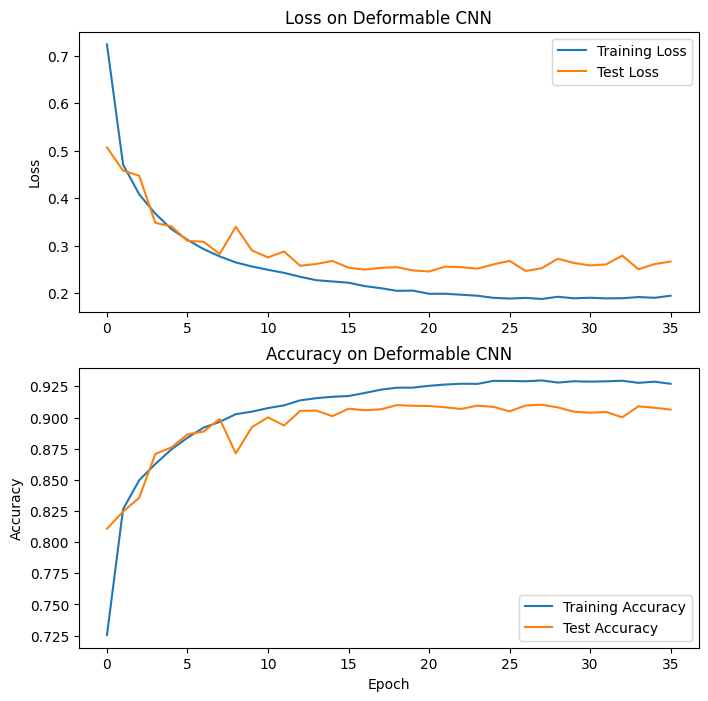

In [9]:
# Create a figure with larger subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))  # Adjust the figsize as needed
ax1.set_title("Loss on Deformable CNN")
# Plot the training and test loss on the first subplot
ax1.plot(batch_tr_info[BATCH_SIZE]["loss"], label="Training Loss")
ax1.plot(batch_te_info[BATCH_SIZE]["loss"], label="Test Loss")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.set_title("Accuracy on Deformable CNN")
# Plot the training and test accuracy on the second subplot
ax2.plot(batch_tr_info[BATCH_SIZE]["acc"], label="Training Accuracy")
ax2.plot(batch_te_info[BATCH_SIZE]["acc"], label="Test Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend()

# Show the plot
plt.show()

## Best test loss for each batch size with it's corresponding accuracy

In [10]:
for batch_size, info in batch_te_info.items():
    best_test_loss = 100
    best_epoch = 0
    for epoch, loss in enumerate(info["loss"]):
        if best_test_loss > loss:
            best_test_loss = loss
            best_epoch = epoch
    print(f"Epoch {best_epoch+1} has {round(best_test_loss, 3)} loss with {round(info['acc'][best_epoch]*100, 2)}% "
          f"accuracy")

Epoch 21 has 0.246 loss with 90.92% accuracy


In [9]:
batch_sizes = [BATCH_SIZE]

model_deform_cutmix = MNISTClassifier(deformable=True)

In [10]:
cutmix_batch_tr_info, cutmix_batch_te_info = train_and_eval(model=model_deform_cutmix, trainset=trainset, testset=testset, batch_sizes=batch_sizes,
                                              NAME_OF_MODEL=NAME_OF_MODEL, folder_to_save_in="cutmix", cutmix=True,
                                              NUM_OF_EPOCHS=NUM_OF_EPOCHS,
                                              early_stopping_patience=EARLY_STOPPING_PATIENCE, NUM_OF_WORKERS=NUM_OF_WORKERS)

Device: cuda:0
Epoch 1 Training...


100%|██████████| 1875/1875 [00:13<00:00, 138.44it/s]


Epoch 1 Testing...


100%|██████████| 313/313 [00:04<00:00, 74.85it/s] 


Epoch 1: Train_accuracy: 54.33%, Train_loss: 1.515816, Test_accuracy: 75.97%, Test_loss: 0.646417
Epoch 2 Training...


100%|██████████| 1875/1875 [00:13<00:00, 136.11it/s]


Epoch 2 Testing...


100%|██████████| 313/313 [00:04<00:00, 77.30it/s] 


Epoch 2: Train_accuracy: 67.14%, Train_loss: 1.282180, Test_accuracy: 81.34%, Test_loss: 0.529310
Epoch 3 Training...


100%|██████████| 1875/1875 [00:13<00:00, 138.55it/s]


Epoch 3 Testing...


100%|██████████| 313/313 [00:04<00:00, 74.61it/s] 


Epoch 3: Train_accuracy: 70.37%, Train_loss: 1.207266, Test_accuracy: 83.00%, Test_loss: 0.511062
Epoch 4 Training...


100%|██████████| 1875/1875 [00:13<00:00, 137.37it/s]


Epoch 4 Testing...


100%|██████████| 313/313 [00:04<00:00, 75.76it/s] 


Epoch 4: Train_accuracy: 72.55%, Train_loss: 1.164258, Test_accuracy: 85.91%, Test_loss: 0.447536
Epoch 5 Training...


100%|██████████| 1875/1875 [00:13<00:00, 139.52it/s]


Epoch 5 Testing...


100%|██████████| 313/313 [00:04<00:00, 77.21it/s] 


Epoch 5: Train_accuracy: 74.26%, Train_loss: 1.111109, Test_accuracy: 86.70%, Test_loss: 0.404154
Epoch 6 Training...


100%|██████████| 1875/1875 [00:13<00:00, 134.39it/s]


Epoch 6 Testing...


100%|██████████| 313/313 [00:03<00:00, 78.53it/s] 


Epoch 6: Train_accuracy: 74.59%, Train_loss: 1.093752, Test_accuracy: 86.68%, Test_loss: 0.410340
Epoch 7 Training...


100%|██████████| 1875/1875 [00:14<00:00, 131.19it/s]


Epoch 7 Testing...


100%|██████████| 313/313 [00:04<00:00, 75.16it/s] 


Epoch 7: Train_accuracy: 75.85%, Train_loss: 1.068416, Test_accuracy: 87.92%, Test_loss: 0.392203
Epoch 8 Training...


100%|██████████| 1875/1875 [00:13<00:00, 140.51it/s]


Epoch 8 Testing...


100%|██████████| 313/313 [00:04<00:00, 77.91it/s] 


Epoch 8: Train_accuracy: 76.08%, Train_loss: 1.051107, Test_accuracy: 87.85%, Test_loss: 0.370695
Epoch 9 Training...


100%|██████████| 1875/1875 [00:13<00:00, 139.15it/s]


Epoch 9 Testing...


100%|██████████| 313/313 [00:04<00:00, 75.44it/s] 


Epoch 9: Train_accuracy: 76.54%, Train_loss: 1.039387, Test_accuracy: 88.38%, Test_loss: 0.365450
Epoch 10 Training...


100%|██████████| 1875/1875 [00:13<00:00, 134.65it/s]


Epoch 10 Testing...


100%|██████████| 313/313 [00:04<00:00, 78.07it/s] 


Epoch 10: Train_accuracy: 76.84%, Train_loss: 1.022167, Test_accuracy: 88.59%, Test_loss: 0.375784
Epoch 11 Training...


100%|██████████| 1875/1875 [00:13<00:00, 141.16it/s]


Epoch 11 Testing...


100%|██████████| 313/313 [00:03<00:00, 78.56it/s] 


Epoch 11: Train_accuracy: 77.16%, Train_loss: 1.006268, Test_accuracy: 88.88%, Test_loss: 0.345669
Epoch 12 Training...


100%|██████████| 1875/1875 [00:13<00:00, 140.39it/s]


Epoch 12 Testing...


100%|██████████| 313/313 [00:04<00:00, 75.00it/s] 


Epoch 12: Train_accuracy: 77.75%, Train_loss: 0.987763, Test_accuracy: 88.54%, Test_loss: 0.362365
Epoch 13 Training...


100%|██████████| 1875/1875 [00:13<00:00, 142.59it/s]


Epoch 13 Testing...


100%|██████████| 313/313 [00:04<00:00, 75.42it/s] 


Epoch 13: Train_accuracy: 77.75%, Train_loss: 0.985184, Test_accuracy: 89.43%, Test_loss: 0.340387
Epoch 14 Training...


100%|██████████| 1875/1875 [00:13<00:00, 139.70it/s]


Epoch 14 Testing...


100%|██████████| 313/313 [00:03<00:00, 79.83it/s] 


Epoch 14: Train_accuracy: 77.45%, Train_loss: 0.987098, Test_accuracy: 88.80%, Test_loss: 0.356044
Epoch 15 Training...


100%|██████████| 1875/1875 [00:13<00:00, 140.75it/s]


Epoch 15 Testing...


100%|██████████| 313/313 [00:03<00:00, 79.76it/s] 


Epoch 15: Train_accuracy: 78.27%, Train_loss: 0.969774, Test_accuracy: 89.90%, Test_loss: 0.330377
Epoch 16 Training...


100%|██████████| 1875/1875 [00:13<00:00, 134.94it/s]


Epoch 16 Testing...


100%|██████████| 313/313 [00:04<00:00, 72.80it/s] 


Epoch 16: Train_accuracy: 78.00%, Train_loss: 0.970138, Test_accuracy: 89.58%, Test_loss: 0.334243
Epoch 17 Training...


100%|██████████| 1875/1875 [00:13<00:00, 141.28it/s]


Epoch 17 Testing...


100%|██████████| 313/313 [00:04<00:00, 78.21it/s] 


Epoch 17: Train_accuracy: 77.60%, Train_loss: 0.979460, Test_accuracy: 89.43%, Test_loss: 0.341981
Epoch 18 Training...


100%|██████████| 1875/1875 [00:13<00:00, 141.01it/s]


Epoch 18 Testing...


100%|██████████| 313/313 [00:04<00:00, 77.39it/s] 


Epoch 18: Train_accuracy: 77.66%, Train_loss: 0.968242, Test_accuracy: 89.56%, Test_loss: 0.344926
Epoch 19 Training...


100%|██████████| 1875/1875 [00:13<00:00, 141.63it/s]


Epoch 19 Testing...


100%|██████████| 313/313 [00:04<00:00, 77.58it/s] 


Epoch 19: Train_accuracy: 78.40%, Train_loss: 0.959522, Test_accuracy: 90.40%, Test_loss: 0.317337
Epoch 20 Training...


100%|██████████| 1875/1875 [00:12<00:00, 144.27it/s]


Epoch 20 Testing...


100%|██████████| 313/313 [00:04<00:00, 77.15it/s] 


Epoch 20: Train_accuracy: 78.08%, Train_loss: 0.952715, Test_accuracy: 89.95%, Test_loss: 0.322181
Epoch 21 Training...


100%|██████████| 1875/1875 [00:13<00:00, 143.10it/s]


Epoch 21 Testing...


100%|██████████| 313/313 [00:03<00:00, 79.07it/s] 


Epoch 21: Train_accuracy: 78.68%, Train_loss: 0.951827, Test_accuracy: 90.12%, Test_loss: 0.322887
Epoch 22 Training...


100%|██████████| 1875/1875 [00:13<00:00, 143.90it/s]


Epoch 22 Testing...


100%|██████████| 313/313 [00:04<00:00, 77.28it/s] 


Epoch 22: Train_accuracy: 78.91%, Train_loss: 0.944714, Test_accuracy: 90.14%, Test_loss: 0.321842
Epoch 23 Training...


100%|██████████| 1875/1875 [00:13<00:00, 138.81it/s]


Epoch 23 Testing...


100%|██████████| 313/313 [00:03<00:00, 78.76it/s] 


Epoch 23: Train_accuracy: 79.14%, Train_loss: 0.931133, Test_accuracy: 90.08%, Test_loss: 0.320842
Epoch 24 Training...


100%|██████████| 1875/1875 [00:13<00:00, 137.19it/s]


Epoch 24 Testing...


100%|██████████| 313/313 [00:04<00:00, 77.38it/s] 


Epoch 24: Train_accuracy: 79.21%, Train_loss: 0.932540, Test_accuracy: 90.42%, Test_loss: 0.306953
Epoch 25 Training...


100%|██████████| 1875/1875 [00:13<00:00, 139.98it/s]


Epoch 25 Testing...


100%|██████████| 313/313 [00:04<00:00, 76.70it/s] 


Epoch 25: Train_accuracy: 79.54%, Train_loss: 0.923494, Test_accuracy: 90.42%, Test_loss: 0.303550
Epoch 26 Training...


100%|██████████| 1875/1875 [00:13<00:00, 140.70it/s]


Epoch 26 Testing...


100%|██████████| 313/313 [00:03<00:00, 80.66it/s] 


Epoch 26: Train_accuracy: 78.82%, Train_loss: 0.931315, Test_accuracy: 90.40%, Test_loss: 0.323920
Epoch 27 Training...


100%|██████████| 1875/1875 [00:13<00:00, 142.54it/s]


Epoch 27 Testing...


100%|██████████| 313/313 [00:04<00:00, 75.98it/s] 


Epoch 27: Train_accuracy: 79.00%, Train_loss: 0.935077, Test_accuracy: 90.22%, Test_loss: 0.316321
Epoch 28 Training...


100%|██████████| 1875/1875 [00:12<00:00, 144.31it/s]


Epoch 28 Testing...


100%|██████████| 313/313 [00:04<00:00, 78.18it/s] 


Epoch 28: Train_accuracy: 78.66%, Train_loss: 0.930253, Test_accuracy: 90.06%, Test_loss: 0.319226
Epoch 29 Training...


100%|██████████| 1875/1875 [00:13<00:00, 140.96it/s]


Epoch 29 Testing...


100%|██████████| 313/313 [00:03<00:00, 80.83it/s] 


Epoch 29: Train_accuracy: 79.14%, Train_loss: 0.919412, Test_accuracy: 90.73%, Test_loss: 0.315472
Epoch 30 Training...


100%|██████████| 1875/1875 [00:13<00:00, 140.92it/s]


Epoch 30 Testing...


100%|██████████| 313/313 [00:03<00:00, 79.19it/s] 


Epoch 30: Train_accuracy: 79.31%, Train_loss: 0.913148, Test_accuracy: 90.31%, Test_loss: 0.314750
Epoch 31 Training...


100%|██████████| 1875/1875 [00:13<00:00, 142.51it/s]


Epoch 31 Testing...


100%|██████████| 313/313 [00:04<00:00, 76.35it/s] 


Epoch 31: Train_accuracy: 79.34%, Train_loss: 0.915188, Test_accuracy: 90.77%, Test_loss: 0.303987
Epoch 32 Training...


100%|██████████| 1875/1875 [00:13<00:00, 141.43it/s]


Epoch 32 Testing...


100%|██████████| 313/313 [00:03<00:00, 81.02it/s] 


Epoch 32: Train_accuracy: 78.55%, Train_loss: 0.921921, Test_accuracy: 90.42%, Test_loss: 0.303233
Epoch 33 Training...


100%|██████████| 1875/1875 [00:12<00:00, 144.76it/s]


Epoch 33 Testing...


100%|██████████| 313/313 [00:03<00:00, 80.12it/s] 


Epoch 33: Train_accuracy: 79.61%, Train_loss: 0.904835, Test_accuracy: 90.67%, Test_loss: 0.299458
Epoch 34 Training...


100%|██████████| 1875/1875 [00:12<00:00, 145.25it/s]


Epoch 34 Testing...


100%|██████████| 313/313 [00:04<00:00, 76.55it/s] 


Epoch 34: Train_accuracy: 78.86%, Train_loss: 0.927346, Test_accuracy: 90.79%, Test_loss: 0.296029
Epoch 35 Training...


100%|██████████| 1875/1875 [00:13<00:00, 143.69it/s]


Epoch 35 Testing...


100%|██████████| 313/313 [00:03<00:00, 79.50it/s] 


Epoch 35: Train_accuracy: 80.00%, Train_loss: 0.902173, Test_accuracy: 90.48%, Test_loss: 0.309321
Epoch 36 Training...


100%|██████████| 1875/1875 [00:13<00:00, 142.59it/s]


Epoch 36 Testing...


100%|██████████| 313/313 [00:03<00:00, 79.94it/s] 


Epoch 36: Train_accuracy: 79.34%, Train_loss: 0.902931, Test_accuracy: 90.74%, Test_loss: 0.307789
Epoch 37 Training...


100%|██████████| 1875/1875 [00:13<00:00, 142.13it/s]


Epoch 37 Testing...


100%|██████████| 313/313 [00:04<00:00, 73.50it/s] 


Epoch 37: Train_accuracy: 79.55%, Train_loss: 0.901526, Test_accuracy: 91.12%, Test_loss: 0.297436
Epoch 38 Training...


100%|██████████| 1875/1875 [00:13<00:00, 135.44it/s]


Epoch 38 Testing...


100%|██████████| 313/313 [00:04<00:00, 65.85it/s] 


Epoch 38: Train_accuracy: 79.10%, Train_loss: 0.913012, Test_accuracy: 90.51%, Test_loss: 0.310290
Epoch 39 Training...


100%|██████████| 1875/1875 [00:14<00:00, 126.65it/s]


Epoch 39 Testing...


100%|██████████| 313/313 [00:04<00:00, 72.35it/s] 


Epoch 39: Train_accuracy: 80.00%, Train_loss: 0.905770, Test_accuracy: 91.14%, Test_loss: 0.299434
Epoch 40 Training...


100%|██████████| 1875/1875 [00:13<00:00, 134.36it/s]


Epoch 40 Testing...


100%|██████████| 313/313 [00:04<00:00, 77.53it/s] 

Epoch 40: Train_accuracy: 79.68%, Train_loss: 0.899582, Test_accuracy: 90.70%, Test_loss: 0.298384


In [11]:
file_path = 'training_information/deformable_cnn/cutmix/batch_te_info.pkl'
with open(file_path, 'rb') as file:
    cutmix_batch_te_info = pickle.load(file)
file_path = 'training_information/deformable_cnn/cutmix/batch_tr_info.pkl'
with open(file_path, 'rb') as file:
    cutmix_batch_tr_info = pickle.load(file)

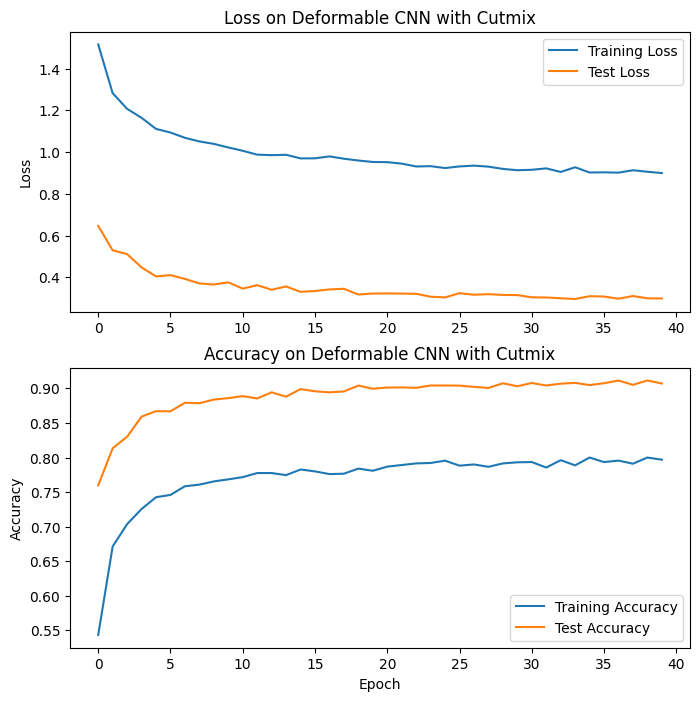

In [30]:
# Create a figure with larger subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))  # Adjust the figsize as needed
# Plot the training and test loss on the first subplot
ax1.set_title("Loss on Deformable CNN with Cutmix")
ax1.plot(cutmix_batch_tr_info[BATCH_SIZE]["loss"], label="Training Loss")
ax1.plot(cutmix_batch_te_info[BATCH_SIZE]["loss"], label="Test Loss")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.set_title("Accuracy on Deformable CNN with Cutmix")
# Plot the training and test accuracy on the second subplot
ax2.plot(cutmix_batch_tr_info[BATCH_SIZE]["acc"], label="Training Accuracy")
ax2.plot(cutmix_batch_te_info[BATCH_SIZE]["acc"], label="Test Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend()

# Show the plot
plt.show()

## Best test loss for each batch size with it's corresponding accuracy

In [12]:
for batch_size, info in cutmix_batch_te_info.items():
    best_test_loss = 100
    best_epoch = 0
    for epoch, loss in enumerate(info["loss"]):
        if best_test_loss > loss:
            best_test_loss = loss
            best_epoch = epoch
    print(f"Batch size {batch_size}: Epoch {best_epoch+1} has {round(best_test_loss, 3)} loss with {round(info['acc'][best_epoch]*100, 2)}% accuracy")

Batch size 32: Epoch 34 has 0.296 loss with 90.79% accuracy
